In [1]:
import pandas as pd
from signalai.config import CONFIG_DIR, PIPELINE_SAVE_PATH
from taskorganizer.pipeline import Pipeline
from signalai.signal_tools.signal import SignalDataset, Signal

import seaborn as sns
from matplotlib import pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from inceptiontime import InceptionBlock, InceptionModule
from tqdm import tqdm, trange
import numpy as np

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [2]:
from scipy import signal
def gauss_convolve(arr, window_length, rel_std):
    window = signal.windows.gaussian(window_length, std=window_length * rel_std)
    window = window / np.sum(window)
    c = np.array([np.convolve(arr[i, :], window, mode='same') for i in range(arr.shape[0])])

    return c

In [3]:
config_path = CONFIG_DIR / "processing" / "pipeline.yaml"
params_config_path = CONFIG_DIR / "data_preparation" / "tahovka0.yaml"
pip = Pipeline(
    config_path,
    config_dir=CONFIG_DIR,
    save_folder=PIPELINE_SAVE_PATH,
    parameter_yamls=[params_config_path]
)

device = "cuda"

In [4]:
df = pip.run("DatasetLoader")

In [5]:
df.sample(4)

,dataset,dataset_id,filename,filename_id,channel_id,split,interval_start,interval_end,interval_length,values,frequency,big_endian,source_dtype,dtype_bytes,signed,op_dtype,to_ram,standardize,adjustment,dataset_total
14,tahovka_plastized,1,/mnt/280EB8D100D42ACE/Datasets/AE stream/AE-DA...,tahovka_plastized-AE-DATA-conti-73802957669129...,0,train,946718750,1066359375,119640625,1072656250,1562500,True,float32,4,True,float32,True,False,0,4
3,noise,3,/mnt/AXAGO/Martin/signalai/noise/AE-DATA-conti...,noise-AE-DATA-conti-7384138907242477-ch1.bin-0...,0,valid,164765625,164765625,0,173437500,1562500,True,float32,4,True,float32,True,False,0,4
2,noise,3,/mnt/AXAGO/Martin/signalai/noise/AE-DATA-conti...,noise-AE-DATA-conti-7384138907242477-ch1.bin-0...,0,train,0,164765625,164765625,173437500,1562500,True,float32,4,True,float32,True,False,0,4
15,tahovka_plastized,1,/mnt/280EB8D100D42ACE/Datasets/AE stream/AE-DA...,tahovka_plastized-AE-DATA-conti-73802957669129...,0,valid,1066359375,1066359375,0,1072656250,1562500,True,float32,4,True,float32,True,False,0,4


In [6]:
gen_gen = pip.run("data_generator")

Loading datasets ['noise', 'tahovka_normal', 'tahovka_plastized'] to RAM: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s]


In [7]:
train_gen = gen_gen.get_generator("train", log=0, batch_size=16)

t0 False
t1 32734
noise False


In [8]:
#gen_gen.signal_loader.loaded_signals["tahovka_normal-0-test"].signal.shape

In [9]:
%%time
for i in tqdm(range(1000)):
    X, Y = next(train_gen)
    _=torch.from_numpy(np.array(X)).to(device)
    _=torch.from_numpy(np.array(Y)).to(device)
        

100%|██████████| 1000/1000 [00:03<00:00, 258.49it/s]

CPU times: user 3.47 s, sys: 379 ms, total: 3.85 s
Wall time: 3.87 s


<AxesSubplot:>

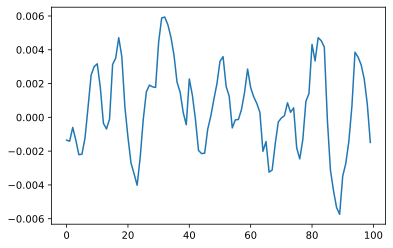

In [10]:
sns.lineplot(x=range(100), y=X[0][0][:100])

In [11]:
### TEMP

class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
    
net = nn.Sequential(
    InceptionBlock(
        in_channels=1,
        n_filters=32,
        kernel_sizes=[11, 21, 41],
        bottleneck_channels=32,
        use_residual=True,
        activation=nn.SELU()
    ),
    nn.AdaptiveAvgPool1d(output_size=1),
    Flatten(out_features=32 * 4 * 1),
    nn.Linear(in_features=4 * 32 * 1, out_features=1),
    nn.Sigmoid()
).to(device)

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.inception_block1 = InceptionBlock(
            in_channels=1,
            n_filters=32,
            kernel_sizes=[11, 21, 41],
            bottleneck_channels=32,
            use_residual=True,
            activation=nn.SELU()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size=1)
        self.linear1 = nn.Linear(in_features=4 * 32 * 1, out_features=1)
        self.out_activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.inception_block1(x)
        x = self.adaptive_pool(x)
        x = x.view(-1, 32 * 4 * 1)
        x = self.linear1(x)
        y = self.out_activation(x)
        return y

    
net = Net().to(device)

In [12]:
# torch.onnx.export(net, torch.from_numpy(np.array(X)[:1]).to(device), "net.onnx")

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []

In [18]:
def evaluate(model, output_name):
    torch.save(model.state_dict(), output_name+".pth")
    model.eval()
    with torch.no_grad():
        all_gen = gen_gen.get_generator(split=None, log=0, batch_size=32, x="X_all", y="Y_all")
        result = []
        for i in range(1072656250 // 32 // 32734):
            X, _ = next(all_gen)
            inputs = torch.from_numpy(np.array(X)).to(device)
            result += list(model(inputs).cpu())

        np_results = np.array([i.numpy() for i in result])[:,0]
        plt.figure(figsize=(16,9))
        sns.lineplot(y=gauss_convolve(np.expand_dims(np_results, 0), 30, 0.8)[0], x=range(len(np_results)))
        plt.savefig(output_name+".svg")

    model.train()

In [ ]:
echo_step = 300
save_step = 1500
average_losses = 300
batches_id = trange(30000)

for train_batch in batches_id:  # loop over the dataset multiple times
    
    # optimizer = optim.Adam(net.parameters(), lr=0.01)
    X, Y = next(train_gen)
    inputs = torch.from_numpy(np.array(X)).to(device)
    labels = torch.from_numpy(np.array(Y)).type(torch.float32).unsqueeze(1).to(device)
    # print(labels)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    mean_loss = np.mean(losses[-average_losses:])
    if mean_loss < 1e-5:
        break
    # print statistics
    losses.append(loss.item())
    batches_id.set_description(f"Loss: {mean_loss: .08f}")
    if train_batch % echo_step == 0:
        print()
    
    if train_batch % save_step == 0 and train_batch > 0:
        evaluate(net, f"tahovka/{train_batch}-noise-adam0.01")
        
evaluate(net, f"tahovka/{train_batch}-noise-adam0.01")
print('Finished Training')

In [ ]:
# alternative train

In [14]:
all_signal = np.fromfile(open('/mnt/280EB8D100D42ACE/Datasets/200915_AE.bin',"r"), dtype="float32")

  0%|          | 0/300001 [00:00<?, ?it/s]/home/martin/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martin/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Loss:  nan:   0%|          | 1/300001 [00:00<37:22:32,  2.23it/s]

Loss:  0.00003485:   0%|          | 401/300001 [04:19<20:50:55,  3.99it/s]  

Loss:  0.00002108:   0%|          | 600/300001 [05:27<45:22:59,  1.83it/s]


KeyboardInterrupt: 

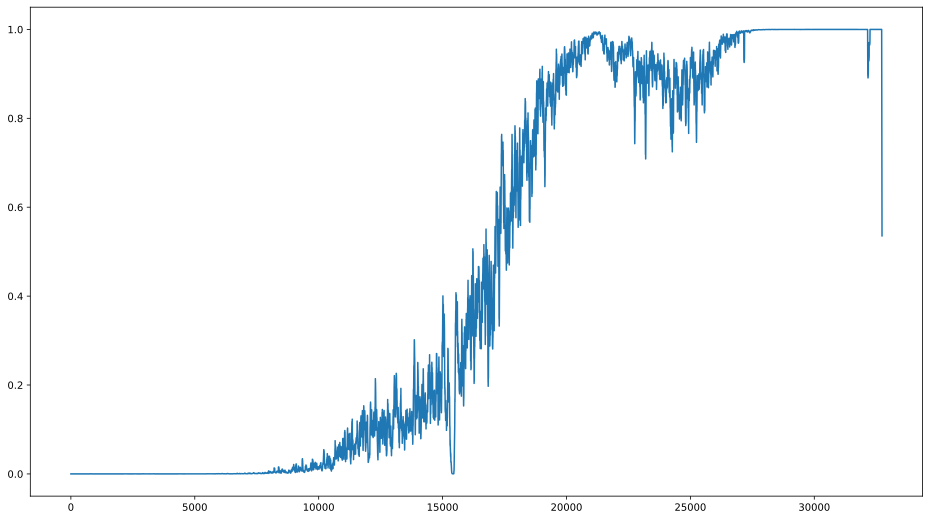

In [16]:
echo_step = 400
save_step = 300
x_size = 32768
batch_size = 16
average_losses = 300
batches_id = trange(300001)

for train_batch in batches_id:  # loop over the dataset multiple times
    chosen = [(np.random.randint(15625000, 62500000),0) for i in range(int(batch_size/2))] + [(np.random.randint(966718750, 1010156250),1) for i in range(int(batch_size/2))]
    np.random.shuffle(chosen)
    
    inputs = torch.from_numpy(np.expand_dims(np.vstack([all_signal[i[0]:i[0]+x_size] for i in chosen]), 1)).to(device)
    labels = torch.from_numpy(np.array([i[1] for i in chosen])).type(torch.float32).unsqueeze(1).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # print statistics
    losses.append(loss.item())
    
    mean_loss= np.mean(losses[-average_losses:])
    if mean_loss < 3e-5:
        break
        
    batches_id.set_description(f"Loss: {mean_loss: .08f}")
    if train_batch % echo_step == 0:
        print()
    
    if train_batch % save_step == 0 and train_batch > 0:
        evaluate(net, f'pokus_manual_32K/tahovka{train_batch}_net_better_adam')

evaluate(net, f'pokus_manual_32K/tahovka{train_batch}_net_better_adam')
print('Finished Training')